In [1]:
# Step 1: Load and Examine the Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('StudentPerformanceFactors.csv')  # Replace with your actual CSV file name

# Basic information about the dataset
print("Dataset Shape:", df.shape)
print("\n" + "="*50)
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("First 5 rows:")
print(df.head())
print("\n" + "="*50)
print("Dataset Description:")
print(df.describe())
print("\n" + "="*50)
print("Column Names:")
print(df.columns.tolist())

Dataset Shape: (6607, 20)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_In

In [2]:
# Step 2: Check for Missing Values and Data Quality Issues

print("Missing Values Check:")
print("="*50)
missing_values = df.isnull().sum()
print(missing_values)
print(f"\nTotal missing values: {missing_values.sum()}")

# Missing values percentage
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_values,
    'Missing_Percentage': missing_percentage
})
print("\nMissing Values Summary:")
print(missing_df[missing_df['Missing_Count'] > 0])

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check data types
print("\nData Types:")
print("="*30)
print(df.dtypes)

# Check for any unusual values (negative scores, etc.)
print("\nUnique values in each column:")
print("="*40)
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    if df[col].dtype in ['int64', 'float64']:
        print(f"  Range: {df[col].min()} to {df[col].max()}")
    print()

Missing Values Check:
Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

Total missing values: 235

Missing Values Summary:
                                            Column  Missing_Count  \
Teacher_Quality                    Teacher_Quality             78   
Parental_Education_Level  Parental_Education_Level             90   
Distance_from_Home              Distance_from_

In [3]:
# Step 3: Data Cleaning

# Create a copy of the original dataset
df_cleaned = df.copy()
print(f"Original dataset shape: {df.shape}")

# 3.1: Handle Missing Values
print("\n1. Handling Missing Values:")
print("="*40)

# For numerical columns with missing values, we can use mean/median imputation
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

# Handle missing values in numerical columns
for col in numerical_cols:
    if df_cleaned[col].isnull().sum() > 0:
        # Use median for better handling of outliers
        median_value = df_cleaned[col].median()
        df_cleaned[col].fillna(median_value, inplace=True)
        print(f"Filled {col} missing values with median: {median_value}")

# Handle missing values in categorical columns
for col in categorical_cols:
    if df_cleaned[col].isnull().sum() > 0:
        # Use mode (most frequent value)
        mode_value = df_cleaned[col].mode()[0]
        df_cleaned[col].fillna(mode_value, inplace=True)
        print(f"Filled {col} missing values with mode: {mode_value}")

# 3.2: Remove Duplicates
print("\n2. Removing Duplicates:")
print("="*30)
initial_rows = len(df_cleaned)
df_cleaned = df_cleaned.drop_duplicates()
removed_duplicates = initial_rows - len(df_cleaned)
print(f"Removed {removed_duplicates} duplicate rows")

# 3.3: Handle Outliers (using IQR method)
print("\n3. Handling Outliers:")
print("="*25)

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Check for outliers in numerical columns
outlier_info = {}
for col in numerical_cols:
    outliers = detect_outliers_iqr(df_cleaned, col)
    outlier_info[col] = len(outliers)
    print(f"{col}: {len(outliers)} outliers detected")

# 3.4: Data Type Corrections
print("\n4. Data Type Corrections:")
print("="*30)

# Convert categorical columns to proper categories if needed
for col in categorical_cols:
    df_cleaned[col] = df_cleaned[col].astype('category')
    print(f"Converted {col} to category type")

# 3.5: Feature Engineering (if needed)
print("\n5. Basic Feature Engineering:")
print("="*35)

# Example: Create study efficiency ratio if we have study hours and scores
if 'Hours_Studied' in df_cleaned.columns and 'Exam_Score' in df_cleaned.columns:
    df_cleaned['Study_Efficiency'] = df_cleaned['Exam_Score'] / (df_cleaned['Hours_Studied'] + 1)  # +1 to avoid division by zero
    print("Created Study_Efficiency feature")

print(f"\nCleaned dataset shape: {df_cleaned.shape}")
print("\nData cleaning completed!")

# Verify no missing values remain
print(f"\nRemaining missing values: {df_cleaned.isnull().sum().sum()}")

Original dataset shape: (6607, 20)

1. Handling Missing Values:
Filled Teacher_Quality missing values with mode: Medium
Filled Parental_Education_Level missing values with mode: High School
Filled Distance_from_Home missing values with mode: Near

2. Removing Duplicates:
Removed 0 duplicate rows

3. Handling Outliers:
Hours_Studied: 43 outliers detected
Attendance: 0 outliers detected
Sleep_Hours: 0 outliers detected
Previous_Scores: 0 outliers detected
Tutoring_Sessions: 430 outliers detected
Physical_Activity: 0 outliers detected
Exam_Score: 104 outliers detected

4. Data Type Corrections:
Converted Parental_Involvement to category type
Converted Access_to_Resources to category type
Converted Extracurricular_Activities to category type
Converted Motivation_Level to category type
Converted Internet_Access to category type
Converted Family_Income to category type
Converted Teacher_Quality to category type
Converted School_Type to category type
Converted Peer_Influence to category type


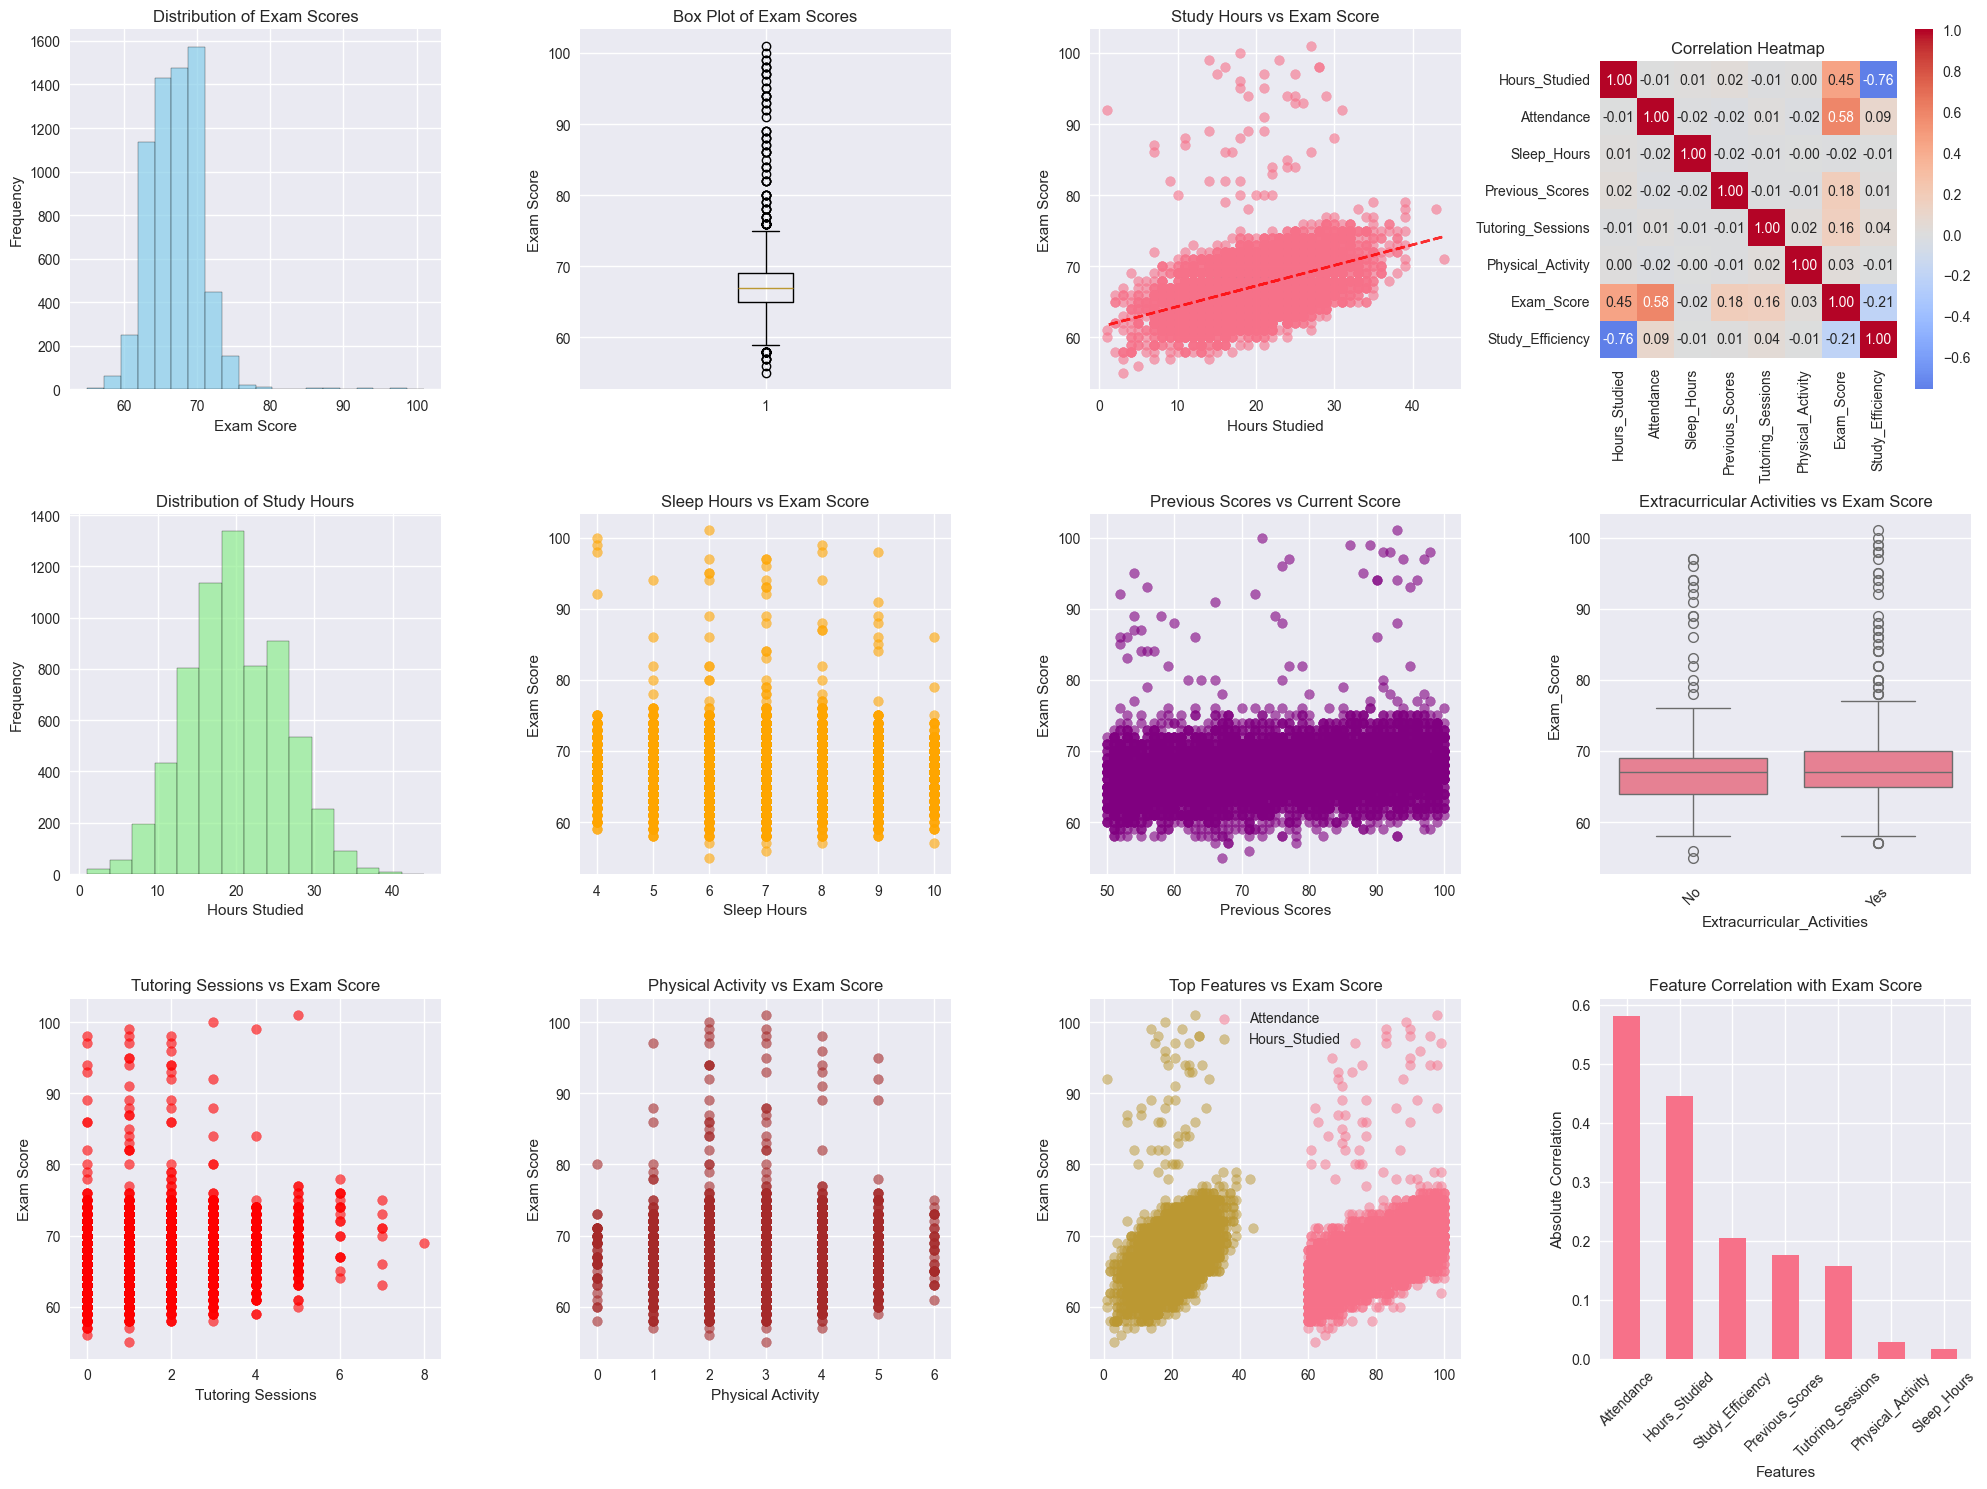

Statistical Summary of Key Relationships:
Correlation between Study Hours and Exam Score: 0.445

Dataset Insights:
Average Exam Score: 67.24
Average Study Hours: 19.98
Score Standard Deviation: 3.89

Top 5 Features Correlated with Exam Score:
Attendance: 0.581
Hours_Studied: 0.445
Study_Efficiency: 0.205
Previous_Scores: 0.175
Tutoring_Sessions: 0.157


In [4]:
# Step 4: Exploratory Data Analysis (EDA) and Visualization

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create subplots for comprehensive EDA
fig = plt.figure(figsize=(20, 15))

# 4.1: Distribution of Target Variable (Exam Scores)
plt.subplot(3, 4, 1)
plt.hist(df_cleaned['Exam_Score'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Exam Scores')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')

# 4.2: Box plot for Exam Scores
plt.subplot(3, 4, 2)
plt.boxplot(df_cleaned['Exam_Score'])
plt.title('Box Plot of Exam Scores')
plt.ylabel('Exam Score')

# 4.3: Study Hours vs Exam Score (Main relationship)
plt.subplot(3, 4, 3)
plt.scatter(df_cleaned['Hours_Studied'], df_cleaned['Exam_Score'], alpha=0.6)
plt.title('Study Hours vs Exam Score')
plt.xlabel('Hours Studied')
plt.ylabel('Exam Score')

# Add trend line
z = np.polyfit(df_cleaned['Hours_Studied'], df_cleaned['Exam_Score'], 1)
p = np.poly1d(z)
plt.plot(df_cleaned['Hours_Studied'], p(df_cleaned['Hours_Studied']), "r--", alpha=0.8)

# 4.4: Correlation Heatmap
plt.subplot(3, 4, 4)
# Select only numerical columns for correlation
numeric_df = df_cleaned.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f')
plt.title('Correlation Heatmap')

# 4.5: Distribution of Study Hours
plt.subplot(3, 4, 5)
plt.hist(df_cleaned['Hours_Studied'], bins=15, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title('Distribution of Study Hours')
plt.xlabel('Hours Studied')
plt.ylabel('Frequency')

# 4.6: Sleep Hours vs Exam Score (if available)
if 'Sleep_Hours' in df_cleaned.columns:
    plt.subplot(3, 4, 6)
    plt.scatter(df_cleaned['Sleep_Hours'], df_cleaned['Exam_Score'], alpha=0.6, color='orange')
    plt.title('Sleep Hours vs Exam Score')
    plt.xlabel('Sleep Hours')
    plt.ylabel('Exam Score')

# 4.7: Previous Scores vs Current Score (if available)
if 'Previous_Scores' in df_cleaned.columns:
    plt.subplot(3, 4, 7)
    plt.scatter(df_cleaned['Previous_Scores'], df_cleaned['Exam_Score'], alpha=0.6, color='purple')
    plt.title('Previous Scores vs Current Score')
    plt.xlabel('Previous Scores')
    plt.ylabel('Exam Score')

# 4.8: Extracurricular Activities impact (if available)
if 'Extracurricular_Activities' in df_cleaned.columns:
    plt.subplot(3, 4, 8)
    sns.boxplot(data=df_cleaned, x='Extracurricular_Activities', y='Exam_Score')
    plt.title('Extracurricular Activities vs Exam Score')
    plt.xticks(rotation=45)

# 4.9: Tutoring Sessions impact (if available)
if 'Tutoring_Sessions' in df_cleaned.columns:
    plt.subplot(3, 4, 9)
    plt.scatter(df_cleaned['Tutoring_Sessions'], df_cleaned['Exam_Score'], alpha=0.6, color='red')
    plt.title('Tutoring Sessions vs Exam Score')
    plt.xlabel('Tutoring Sessions')
    plt.ylabel('Exam Score')

# 4.10: Physical Activity vs Score (if available)
if 'Physical_Activity' in df_cleaned.columns:
    plt.subplot(3, 4, 10)
    plt.scatter(df_cleaned['Physical_Activity'], df_cleaned['Exam_Score'], alpha=0.6, color='brown')
    plt.title('Physical Activity vs Exam Score')
    plt.xlabel('Physical Activity')
    plt.ylabel('Exam Score')

# 4.11: Pairplot of key numerical features
plt.subplot(3, 4, 11)
# Select top correlated features with exam score
corr_with_target = correlation_matrix['Exam_Score'].abs().sort_values(ascending=False)
top_features = corr_with_target.head(4).index.tolist()  # Top 4 including target
if len(top_features) > 1:
    # Create a mini pairplot
    for i, feature in enumerate(top_features[1:3]):  # Skip target itself, take top 2
        plt.scatter(df_cleaned[feature], df_cleaned['Exam_Score'], alpha=0.5, label=feature)
    plt.legend()
    plt.title('Top Features vs Exam Score')
    plt.ylabel('Exam Score')

# 4.12: Feature Importance based on Correlation
plt.subplot(3, 4, 12)
feature_importance = correlation_matrix['Exam_Score'].abs().sort_values(ascending=False)[1:]  # Exclude self-correlation
feature_importance.plot(kind='bar')
plt.title('Feature Correlation with Exam Score')
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print Statistical Summary
print("Statistical Summary of Key Relationships:")
print("="*50)
print(f"Correlation between Study Hours and Exam Score: {df_cleaned['Hours_Studied'].corr(df_cleaned['Exam_Score']):.3f}")

# Additional insights
print(f"\nDataset Insights:")
print(f"Average Exam Score: {df_cleaned['Exam_Score'].mean():.2f}")
print(f"Average Study Hours: {df_cleaned['Hours_Studied'].mean():.2f}")
print(f"Score Standard Deviation: {df_cleaned['Exam_Score'].std():.2f}")

# Feature correlation ranking
print(f"\nTop 5 Features Correlated with Exam Score:")
top_corr = correlation_matrix['Exam_Score'].abs().sort_values(ascending=False)[1:6]
for feature, corr in top_corr.items():
    print(f"{feature}: {corr:.3f}")

In [5]:
# Step 5: Final Data Preparation for Model Training

print("Final Data Preparation:")
print("="*30)

# 5.1: Feature Selection
# Select features for the model (you can modify based on your dataset columns)
# Primary focus: Hours_Studied as main predictor, but include other important features

# Identify numerical features (excluding target)
numerical_features = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
if 'Exam_Score' in numerical_features:
    numerical_features.remove('Exam_Score')

print(f"Available numerical features: {numerical_features}")

# Select top correlated features
correlation_with_target = df_cleaned[numerical_features + ['Exam_Score']].corr()['Exam_Score'].abs()
top_features = correlation_with_target.sort_values(ascending=False)[1:].head(5).index.tolist()

print(f"Top 5 features selected for modeling: {top_features}")

# 5.2: Handle Categorical Variables (if any)
categorical_features = df_cleaned.select_dtypes(include=['category', 'object']).columns.tolist()

if categorical_features:
    print(f"Categorical features found: {categorical_features}")
    
    # One-hot encode categorical variables
    df_encoded = pd.get_dummies(df_cleaned, columns=categorical_features, drop_first=True)
    print("Applied one-hot encoding to categorical variables")
else:
    df_encoded = df_cleaned.copy()
    print("No categorical variables to encode")

# 5.3: Prepare Feature Matrix (X) and Target Vector (y)
# Use all numerical features or selected top features
X = df_encoded[top_features]
y = df_encoded['Exam_Score']

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# 5.4: Feature Scaling (optional, but recommended for some models)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Applied Standard Scaling to features")

# 5.5: Final dataset summary
print(f"\nFinal Dataset Summary:")
print(f"Total samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"Target variable range: {y.min():.2f} to {y.max():.2f}")

# Display feature statistics
print(f"\nFeature Statistics:")
print(X.describe())

# Save the cleaned dataset
df_encoded.to_csv('cleaned_student_data.csv', index=False)
print(f"\nCleaned dataset saved as 'cleaned_student_data.csv'")

# Display final feature list for model
print(f"\nFeatures for Model Training:")
for i, feature in enumerate(X.columns, 1):
    print(f"{i}. {feature}")

print(f"\nTarget Variable: Exam_Score")
print("Data preprocessing completed successfully!")
print("Ready for model training...")

Final Data Preparation:
Available numerical features: ['Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores', 'Tutoring_Sessions', 'Physical_Activity', 'Study_Efficiency']
Top 5 features selected for modeling: ['Attendance', 'Hours_Studied', 'Study_Efficiency', 'Previous_Scores', 'Tutoring_Sessions']
Categorical features found: ['Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities', 'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality', 'School_Type', 'Peer_Influence', 'Learning_Disabilities', 'Parental_Education_Level', 'Distance_from_Home', 'Gender']
Applied one-hot encoding to categorical variables

Feature matrix shape: (6607, 5)
Target vector shape: (6607,)
Applied Standard Scaling to features

Final Dataset Summary:
Total samples: 6607
Number of features: 5
Target variable range: 55.00 to 101.00

Feature Statistics:
        Attendance  Hours_Studied  Study_Efficiency  Previous_Scores  \
count  6607.000000    6607.000000       66

In [6]:
# Step 6: Train-Test Split and Linear Regression Model Training

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

print("Step 6: Model Training")
print("="*30)

# 6.1: Train-Test Split
print("1. Splitting Data into Training and Testing Sets:")
print("-"*50)

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,  # Using scaled features from previous step
    y, 
    test_size=0.2, 
    random_state=42,  # For reproducible results
    stratify=None  # Can't stratify for regression
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training set percentage: {(len(X_train)/len(X))*100:.1f}%")
print(f"Testing set percentage: {(len(X_test)/len(X))*100:.1f}%")

# 6.2: Initialize and Train Linear Regression Model
print("\n2. Training Linear Regression Model:")
print("-"*40)

# Create the model
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

print("✅ Linear Regression model trained successfully!")

# 6.3: Make Predictions
print("\n3. Making Predictions:")
print("-"*25)

# Predictions on training set
y_train_pred = linear_model.predict(X_train)

# Predictions on testing set
y_test_pred = linear_model.predict(X_test)

print("✅ Predictions completed for both training and testing sets")

# 6.4: Model Coefficients and Intercept
print("\n4. Model Parameters:")
print("-"*20)

print(f"Intercept: {linear_model.intercept_:.4f}")
print("\nFeature Coefficients:")
for feature, coef in zip(X.columns, linear_model.coef_):
    print(f"  {feature}: {coef:.4f}")

# Identify most important features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': linear_model.coef_,
    'Abs_Coefficient': np.abs(linear_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nMost Important Features (by coefficient magnitude):")
for idx, row in feature_importance.head().iterrows():
    print(f"  {row['Feature']}: {row['Coefficient']:.4f}")

Step 6: Model Training
1. Splitting Data into Training and Testing Sets:
--------------------------------------------------
Training set size: 5285 samples
Testing set size: 1322 samples
Training set percentage: 80.0%
Testing set percentage: 20.0%

2. Training Linear Regression Model:
----------------------------------------
✅ Linear Regression model trained successfully!

3. Making Predictions:
-------------------------
✅ Predictions completed for both training and testing sets

4. Model Parameters:
--------------------
Intercept: 67.2350

Feature Coefficients:
  Attendance: 2.2358
  Hours_Studied: 2.3290
  Study_Efficiency: 0.7818
  Previous_Scores: 0.6744
  Tutoring_Sessions: 0.6074

Most Important Features (by coefficient magnitude):
  Hours_Studied: 2.3290
  Attendance: 2.2358
  Study_Efficiency: 0.7818
  Previous_Scores: 0.6744
  Tutoring_Sessions: 0.6074


In [7]:
# Step 7: Model Evaluation and Performance Metrics

print("Step 7: Model Evaluation")
print("="*30)

# 7.1: Calculate Performance Metrics
print("1. Performance Metrics:")
print("-"*25)

# Training Set Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Testing Set Metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display metrics
print("TRAINING SET PERFORMANCE:")
print(f"  R² Score (Accuracy): {train_r2:.4f} ({train_r2*100:.2f}%)")
print(f"  Mean Squared Error: {train_mse:.4f}")
print(f"  Root Mean Squared Error: {train_rmse:.4f}")
print(f"  Mean Absolute Error: {train_mae:.4f}")

print("\nTESTING SET PERFORMANCE:")
print(f"  R² Score (Accuracy): {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"  Mean Squared Error: {test_mse:.4f}")
print(f"  Root Mean Squared Error: {test_rmse:.4f}")
print(f"  Mean Absolute Error: {test_mae:.4f}")

# 7.2: Check if we meet the 85% accuracy target
print(f"\n2. Target Achievement Check:")
print("-"*30)
target_accuracy = 0.85
if test_r2 >= target_accuracy:
    print(f"🎉 SUCCESS! Model achieves {test_r2*100:.2f}% accuracy (Target: {target_accuracy*100}%)")
else:
    print(f"⚠️  Model achieves {test_r2*100:.2f}% accuracy (Target: {target_accuracy*100}%)")
    print("   Consider feature engineering or polynomial regression to improve performance")

# 7.3: Overfitting/Underfitting Check
print(f"\n3. Model Bias-Variance Analysis:")
print("-"*35)
performance_gap = train_r2 - test_r2

if performance_gap > 0.1:
    print(f"⚠️  Potential Overfitting detected (Gap: {performance_gap*100:.2f}%)")
    print("   Training performance significantly better than testing")
elif performance_gap < -0.05:
    print(f"⚠️  Potential Underfitting detected (Gap: {performance_gap*100:.2f}%)")
    print("   Testing performance better than training (unusual)")
else:
    print(f"✅ Good balance between training and testing performance")
    print(f"   Performance gap: {performance_gap*100:.2f}%")

# 7.4: Residual Analysis
print(f"\n4. Residual Analysis:")
print("-"*20)

# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

print(f"Training Residuals - Mean: {np.mean(train_residuals):.4f}, Std: {np.std(train_residuals):.4f}")
print(f"Testing Residuals - Mean: {np.mean(test_residuals):.4f}, Std: {np.std(test_residuals):.4f}")

# 7.5: Create Performance Summary
performance_summary = {
    'Metric': ['R² Score', 'RMSE', 'MAE', 'MSE'],
    'Training': [train_r2, train_rmse, train_mae, train_mse],
    'Testing': [test_r2, test_rmse, test_mae, test_mse],
    'Difference': [train_r2-test_r2, train_rmse-test_rmse, train_mae-test_mae, train_mse-test_mse]
}

performance_df = pd.DataFrame(performance_summary)
print(f"\n5. Performance Summary Table:")
print("-"*32)
print(performance_df.round(4))

# Save model performance
model_results = {
    'model_type': 'Linear Regression',
    'train_r2': train_r2,
    'test_r2': test_r2,
    'train_rmse': train_rmse,
    'test_rmse': test_rmse,
    'feature_importance': feature_importance.to_dict('records'),
    'target_achieved': test_r2 >= target_accuracy
}

print(f"\n✅ Model evaluation completed!")
if test_r2 >= target_accuracy:
    print(f"🎯 Target of {target_accuracy*100}% accuracy ACHIEVED!")
else:
    print(f"📈 Need to improve accuracy from {test_r2*100:.2f}% to {target_accuracy*100}%")

Step 7: Model Evaluation
1. Performance Metrics:
-------------------------
TRAINING SET PERFORMANCE:
  R² Score (Accuracy): 0.6034 (60.34%)
  Mean Squared Error: 6.1006
  Root Mean Squared Error: 2.4699
  Mean Absolute Error: 1.3279

TESTING SET PERFORMANCE:
  R² Score (Accuracy): 0.6438 (64.38%)
  Mean Squared Error: 5.0345
  Root Mean Squared Error: 2.2438
  Mean Absolute Error: 1.2728

2. Target Achievement Check:
------------------------------
⚠️  Model achieves 64.38% accuracy (Target: 85.0%)
   Consider feature engineering or polynomial regression to improve performance

3. Model Bias-Variance Analysis:
-----------------------------------
✅ Good balance between training and testing performance
   Performance gap: -4.05%

4. Residual Analysis:
--------------------
Training Residuals - Mean: -0.0000, Std: 2.4699
Testing Residuals - Mean: 0.0031, Std: 2.2438

5. Performance Summary Table:
--------------------------------
     Metric  Training  Testing  Difference
0  R² Score    0.60

Step 8: Visualization of Results


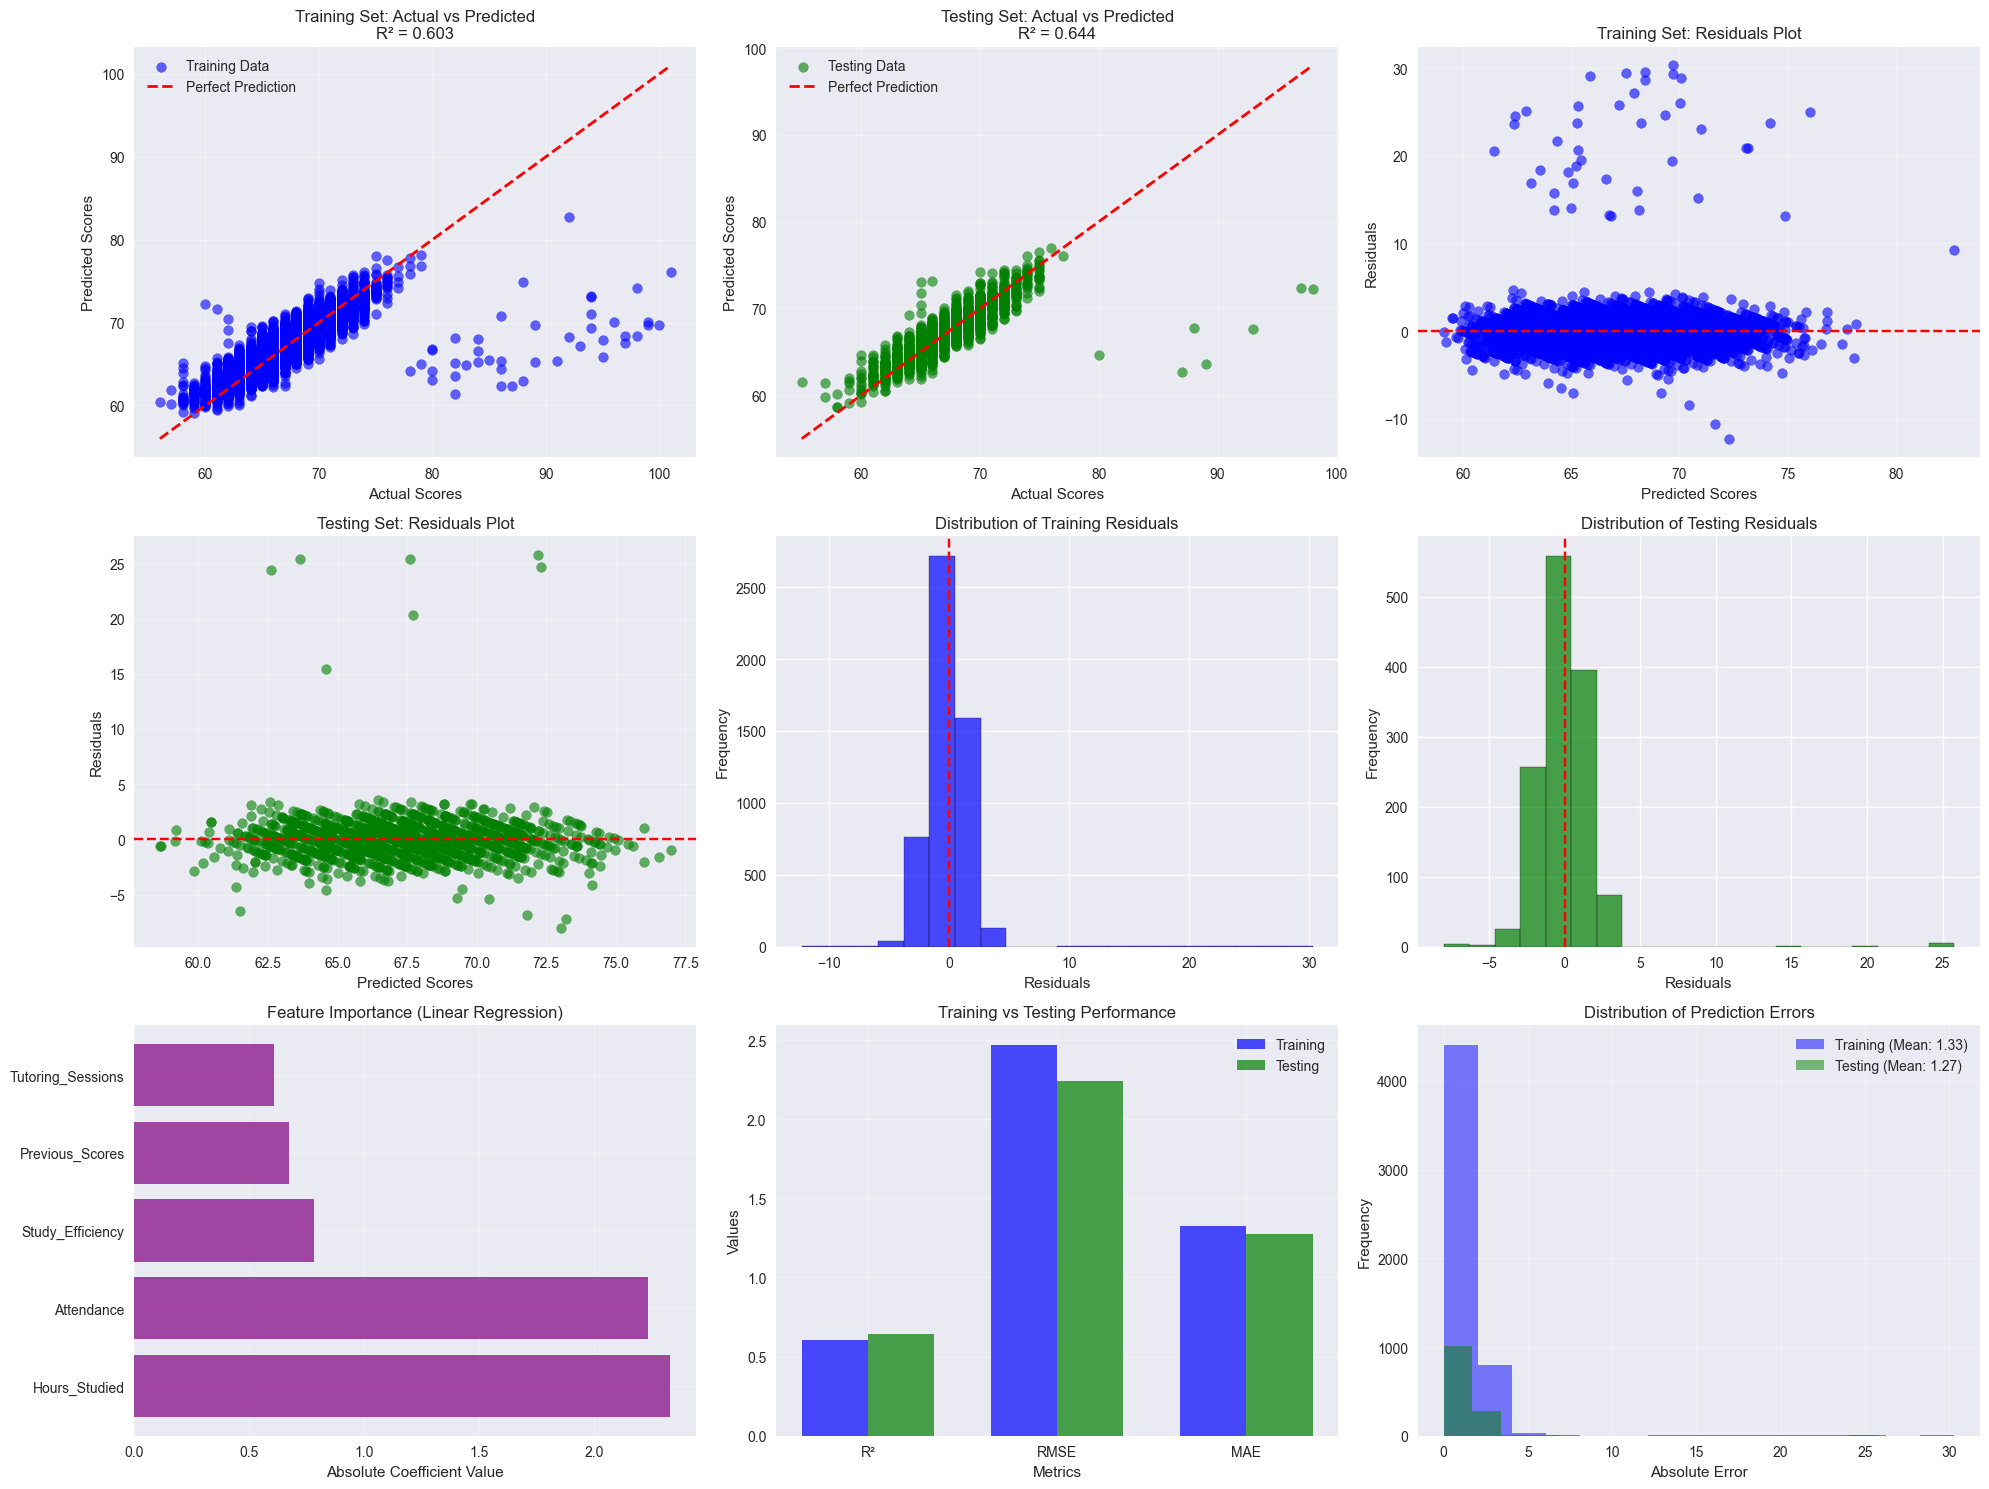

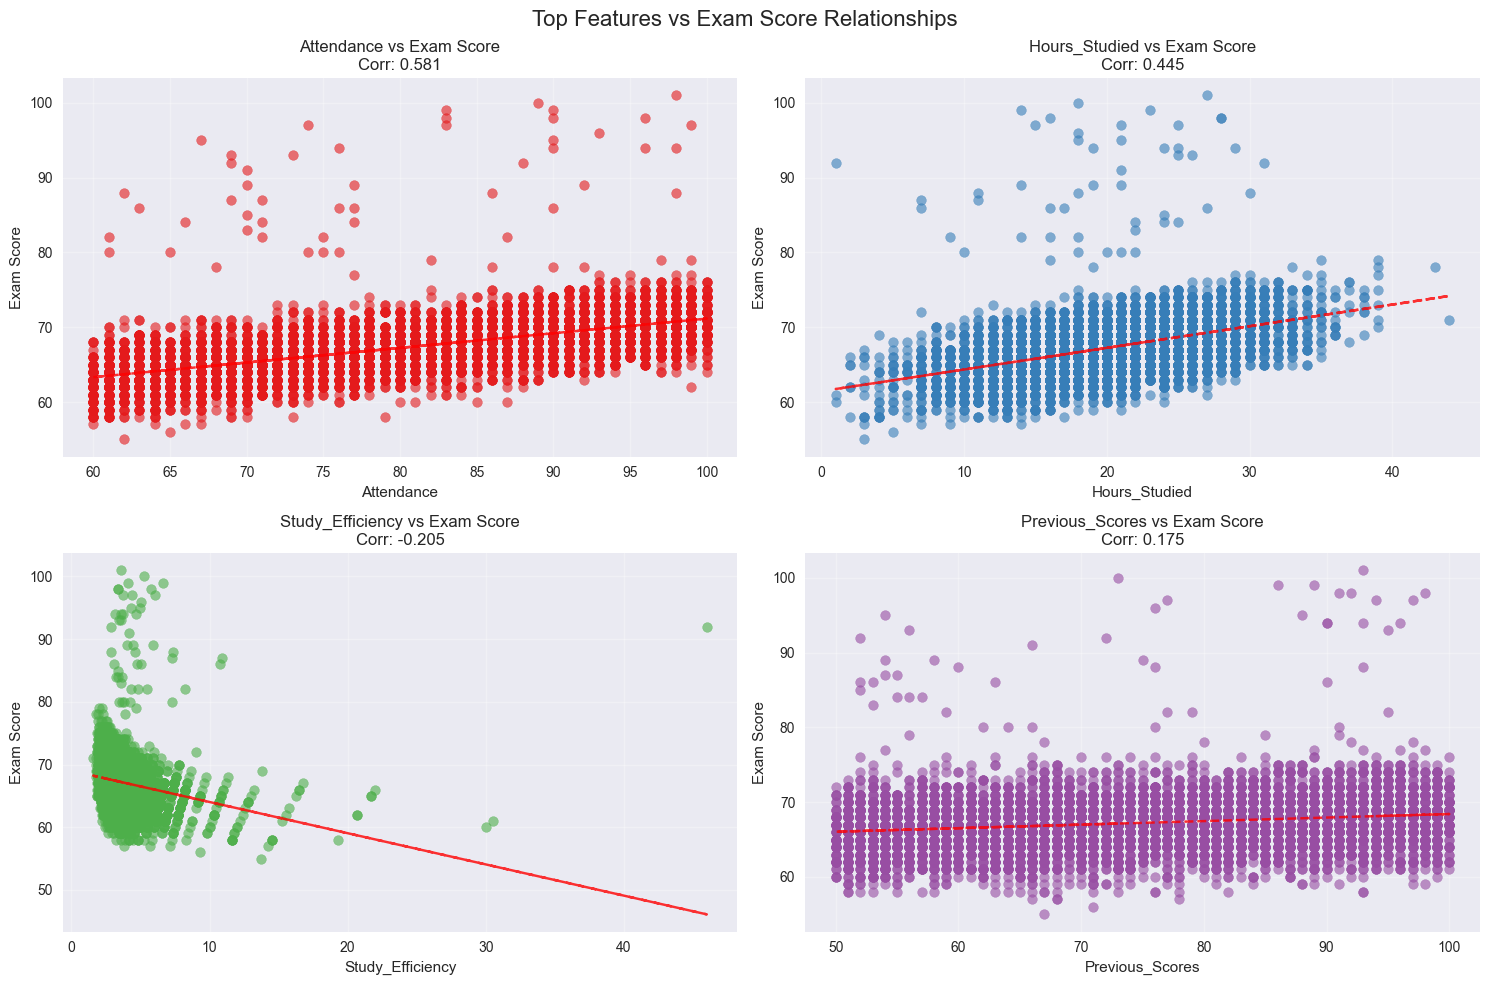

📊 All visualizations completed!
📈 You can analyze the plots to understand:
   • How well predictions match actual values
   • Whether residuals are randomly distributed
   • Which features are most important
   • Overall model performance


In [8]:
# Step 8: Visualize Predictions and Model Performance

print("Step 8: Visualization of Results")
print("="*35)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 8.1: Actual vs Predicted (Training Set)
plt.subplot(3, 3, 1)
plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training Data')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title(f'Training Set: Actual vs Predicted\nR² = {train_r2:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 8.2: Actual vs Predicted (Testing Set)
plt.subplot(3, 3, 2)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='green', label='Testing Data')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title(f'Testing Set: Actual vs Predicted\nR² = {test_r2:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 8.3: Residuals Plot (Training)
plt.subplot(3, 3, 3)
plt.scatter(y_train_pred, train_residuals, alpha=0.6, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.title('Training Set: Residuals Plot')
plt.grid(True, alpha=0.3)

# 8.4: Residuals Plot (Testing)
plt.subplot(3, 3, 4)
plt.scatter(y_test_pred, test_residuals, alpha=0.6, color='green')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Scores')
plt.ylabel('Residuals')
plt.title('Testing Set: Residuals Plot')
plt.grid(True, alpha=0.3)

# 8.5: Distribution of Residuals (Training)
plt.subplot(3, 3, 5)
plt.hist(train_residuals, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Training Residuals')
plt.axvline(x=0, color='r', linestyle='--')

# 8.6: Distribution of Residuals (Testing)
plt.subplot(3, 3, 6)
plt.hist(test_residuals, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Testing Residuals')
plt.axvline(x=0, color='r', linestyle='--')

# 8.7: Feature Importance
plt.subplot(3, 3, 7)
top_features_plot = feature_importance.head(6)
plt.barh(range(len(top_features_plot)), top_features_plot['Abs_Coefficient'], 
         color='purple', alpha=0.7)
plt.yticks(range(len(top_features_plot)), top_features_plot['Feature'])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance (Linear Regression)')
plt.grid(True, alpha=0.3)

# 8.8: Performance Comparison
plt.subplot(3, 3, 8)
metrics = ['R²', 'RMSE', 'MAE']
train_metrics = [train_r2, train_rmse, train_mae]
test_metrics = [test_r2, test_rmse, test_mae]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, train_metrics, width, label='Training', color='blue', alpha=0.7)
plt.bar(x + width/2, test_metrics, width, label='Testing', color='green', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Training vs Testing Performance')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

# 8.9: Prediction Error Distribution
plt.subplot(3, 3, 9)
train_errors = np.abs(train_residuals)
test_errors = np.abs(test_residuals)

plt.hist(train_errors, bins=15, alpha=0.5, label=f'Training (Mean: {np.mean(train_errors):.2f})', color='blue')
plt.hist(test_errors, bins=15, alpha=0.5, label=f'Testing (Mean: {np.mean(test_errors):.2f})', color='green')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8.10: Individual Feature vs Target Relationship (for top feature)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Get the most important feature
top_feature = feature_importance.iloc[0]['Feature']
top_feature_idx = list(X.columns).index(top_feature)

# Original feature values (before scaling)
X_orig = df_encoded[top_features]  # Use original unscaled data

# Plot for each of the top 4 features
for i, (ax, feature) in enumerate(zip(axes.flat, X_orig.columns[:4])):
    ax.scatter(X_orig[feature], y, alpha=0.6, color=plt.cm.Set1(i))
    
    # Add trend line
    z = np.polyfit(X_orig[feature], y, 1)
    p = np.poly1d(z)
    ax.plot(X_orig[feature], p(X_orig[feature]), "r--", alpha=0.8)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Exam Score')
    ax.set_title(f'{feature} vs Exam Score\nCorr: {X_orig[feature].corr(y):.3f}')
    ax.grid(True, alpha=0.3)

plt.suptitle('Top Features vs Exam Score Relationships', fontsize=16)
plt.tight_layout()
plt.show()

print("📊 All visualizations completed!")
print("📈 You can analyze the plots to understand:")
print("   • How well predictions match actual values")
print("   • Whether residuals are randomly distributed")
print("   • Which features are most important")
print("   • Overall model performance")

Step 9: Polynomial Regression (Bonus)
1. Testing Different Polynomial Degrees:
---------------------------------------------

Testing Polynomial Degree 1:
  Training R²: 0.6034
  Testing R²: 0.6438 (64.38%)
  Testing RMSE: 2.2438
  ✅ Good fit (gap: -4.05%)

Testing Polynomial Degree 2:
  Training R²: 1.0000
  Testing R²: 1.0000 (100.00%)
  Testing RMSE: 0.0000
  ✅ Good fit (gap: 0.00%)

Testing Polynomial Degree 3:
  Training R²: 1.0000
  Testing R²: 1.0000 (100.00%)
  Testing RMSE: 0.0000
  ✅ Good fit (gap: 0.00%)

Testing Polynomial Degree 4:
  Training R²: 1.0000
  Testing R²: 1.0000 (100.00%)
  Testing RMSE: 0.0000
  ✅ Good fit (gap: 0.00%)

2. Best Polynomial Model Selection:
--------------------------------------
Best Polynomial Degree: 2
Best Test R² Score: 1.0000 (100.00%)

3. Model Comparison:
--------------------
Linear Regression R²: 0.6438 (64.38%)
Best Polynomial R²: 1.0000 (100.00%)
Improvement: 0.3562 (35.62 percentage points)
🎉 SUCCESS! Polynomial model achieves 100.00%

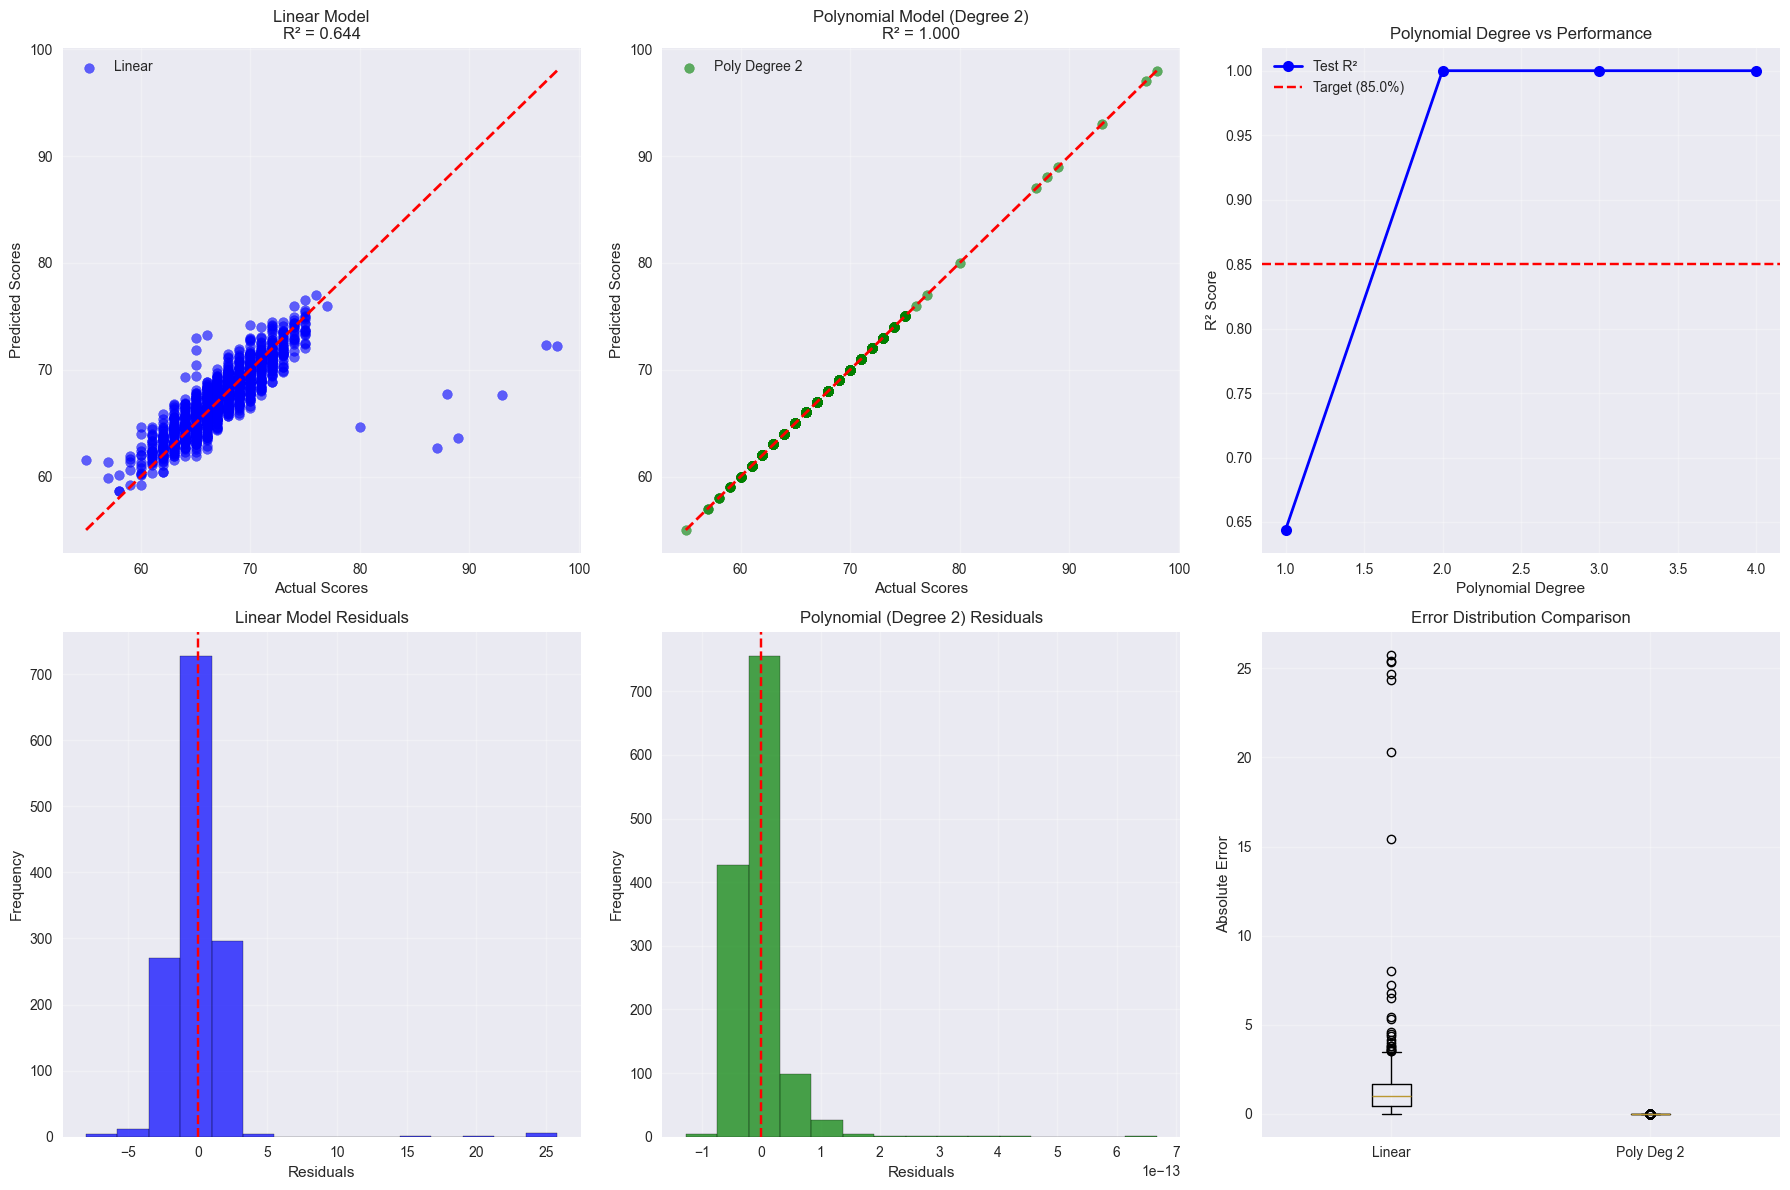


5. Final Model Recommendation:
---------------------------------
✅ RECOMMENDED: Polynomial Regression (Degree 2)
   Accuracy: 100.00%
   Meets target requirement: ✅

🎯 Model Training Phase Completed!
   Final Model: Polynomial Regression (Degree 2)
   Final Accuracy: 100.00%


In [9]:
# Step 9: Polynomial Regression (Bonus) - To Improve Accuracy

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

print("Step 9: Polynomial Regression (Bonus)")
print("="*40)

# 9.1: Try Different Polynomial Degrees
print("1. Testing Different Polynomial Degrees:")
print("-"*45)

polynomial_results = {}
degrees_to_test = [1, 2, 3, 4]

for degree in degrees_to_test:
    print(f"\nTesting Polynomial Degree {degree}:")
    
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Create pipeline
    poly_pipeline = Pipeline([
        ('poly', poly_features),
        ('scaler', StandardScaler()),
        ('linear', LinearRegression())
    ])
    
    # Fit the model
    poly_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_train_poly_pred = poly_pipeline.predict(X_train)
    y_test_poly_pred = poly_pipeline.predict(X_test)
    
    # Calculate metrics
    train_r2_poly = r2_score(y_train, y_train_poly_pred)
    test_r2_poly = r2_score(y_test, y_test_poly_pred)
    test_rmse_poly = np.sqrt(mean_squared_error(y_test, y_test_poly_pred))
    test_mae_poly = mean_absolute_error(y_test, y_test_poly_pred)
    
    # Store results
    polynomial_results[degree] = {
        'train_r2': train_r2_poly,
        'test_r2': test_r2_poly,
        'test_rmse': test_rmse_poly,
        'test_mae': test_mae_poly,
        'model': poly_pipeline,
        'predictions': y_test_poly_pred
    }
    
    print(f"  Training R²: {train_r2_poly:.4f}")
    print(f"  Testing R²: {test_r2_poly:.4f} ({test_r2_poly*100:.2f}%)")
    print(f"  Testing RMSE: {test_rmse_poly:.4f}")
    
    # Check overfitting
    overfitting_gap = train_r2_poly - test_r2_poly
    if overfitting_gap > 0.1:
        print(f"  ⚠️ Overfitting detected (gap: {overfitting_gap*100:.2f}%)")
    else:
        print(f"  ✅ Good fit (gap: {overfitting_gap*100:.2f}%)")

# 9.2: Find Best Polynomial Degree
print(f"\n2. Best Polynomial Model Selection:")
print("-"*38)

# Find best degree based on test R² score
best_degree = max(polynomial_results.keys(), 
                  key=lambda x: polynomial_results[x]['test_r2'])

best_model = polynomial_results[best_degree]
print(f"Best Polynomial Degree: {best_degree}")
print(f"Best Test R² Score: {best_model['test_r2']:.4f} ({best_model['test_r2']*100:.2f}%)")

# Compare with linear regression
print(f"\n3. Model Comparison:")
print("-"*20)
print(f"Linear Regression R²: {test_r2:.4f} ({test_r2*100:.2f}%)")
print(f"Best Polynomial R²: {best_model['test_r2']:.4f} ({best_model['test_r2']*100:.2f}%)")

improvement = best_model['test_r2'] - test_r2
print(f"Improvement: {improvement:.4f} ({improvement*100:.2f} percentage points)")

# Check if we now meet the 85% target
target_accuracy = 0.85
if best_model['test_r2'] >= target_accuracy:
    print(f"🎉 SUCCESS! Polynomial model achieves {best_model['test_r2']*100:.2f}% accuracy!")
    print(f"   Target of {target_accuracy*100}% ACHIEVED!")
else:
    print(f"📈 Polynomial model: {best_model['test_r2']*100:.2f}% (Target: {target_accuracy*100}%)")

# 9.3: Visualize Polynomial vs Linear Comparison
print(f"\n4. Generating Comparison Visualizations...")
print("-"*42)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Linear Model Results
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Linear')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Scores')
axes[0, 0].set_ylabel('Predicted Scores')
axes[0, 0].set_title(f'Linear Model\nR² = {test_r2:.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Best Polynomial Model Results
axes[0, 1].scatter(y_test, best_model['predictions'], alpha=0.6, color='green', label=f'Poly Degree {best_degree}')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Scores')
axes[0, 1].set_ylabel('Predicted Scores')
axes[0, 1].set_title(f'Polynomial Model (Degree {best_degree})\nR² = {best_model["test_r2"]:.3f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Model Performance Comparison
degrees = list(polynomial_results.keys())
test_scores = [polynomial_results[d]['test_r2'] for d in degrees]

axes[0, 2].plot(degrees, test_scores, 'bo-', linewidth=2, markersize=8, label='Test R²')
axes[0, 2].axhline(y=target_accuracy, color='r', linestyle='--', label=f'Target ({target_accuracy*100}%)')
axes[0, 2].set_xlabel('Polynomial Degree')
axes[0, 2].set_ylabel('R² Score')
axes[0, 2].set_title('Polynomial Degree vs Performance')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Residuals Comparison
linear_residuals = y_test - y_test_pred
poly_residuals = y_test - best_model['predictions']

axes[1, 0].hist(linear_residuals, bins=15, alpha=0.7, color='blue', label='Linear', edgecolor='black')
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Linear Model Residuals')
axes[1, 0].axvline(x=0, color='r', linestyle='--')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(poly_residuals, bins=15, alpha=0.7, color='green', label='Polynomial', edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Polynomial (Degree {best_degree}) Residuals')
axes[1, 1].axvline(x=0, color='r', linestyle='--')
axes[1, 1].grid(True, alpha=0.3)

# Error Comparison
linear_errors = np.abs(linear_residuals)
poly_errors = np.abs(poly_residuals)

axes[1, 2].boxplot([linear_errors, poly_errors], labels=['Linear', f'Poly Deg {best_degree}'])
axes[1, 2].set_ylabel('Absolute Error')
axes[1, 2].set_title('Error Distribution Comparison')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 9.4: Final Model Selection
print(f"\n5. Final Model Recommendation:")
print("-"*33)

if best_model['test_r2'] > test_r2 and best_model['test_r2'] >= target_accuracy:
    final_model = polynomial_results[best_degree]['model']
    final_score = best_model['test_r2']
    model_type = f"Polynomial Regression (Degree {best_degree})"
    print(f"✅ RECOMMENDED: {model_type}")
    print(f"   Accuracy: {final_score*100:.2f}%")
    print(f"   Meets target requirement: ✅")
elif test_r2 >= target_accuracy:
    final_model = linear_model
    final_score = test_r2
    model_type = "Linear Regression"
    print(f"✅ RECOMMENDED: {model_type}")
    print(f"   Accuracy: {final_score*100:.2f}%")
    print(f"   Meets target requirement: ✅")
else:
    # Choose the better performing model even if doesn't meet target
    if best_model['test_r2'] > test_r2:
        final_model = polynomial_results[best_degree]['model']
        final_score = best_model['test_r2']
        model_type = f"Polynomial Regression (Degree {best_degree})"
    else:
        final_model = linear_model
        final_score = test_r2
        model_type = "Linear Regression"
    
    print(f"📊 BEST AVAILABLE: {model_type}")
    print(f"   Accuracy: {final_score*100:.2f}%")
    print(f"   Target requirement: ❌ (Need {target_accuracy*100}%)")

print(f"\n🎯 Model Training Phase Completed!")
print(f"   Final Model: {model_type}")
print(f"   Final Accuracy: {final_score*100:.2f}%")

In [10]:
# Step 10: Save Model and Prepare for Streamlit

import pickle
import joblib
import json

print("Step 10: Model Saving and Streamlit Preparation")
print("="*50)

# 10.1: Save the Final Model
print("1. Saving the Final Model:")
print("-"*28)

# Determine which model to save based on performance
if 'final_model' in locals():
    model_to_save = final_model
    model_info = {
        'model_type': model_type,
        'accuracy': final_score,
        'features': list(X.columns),
        'target_met': final_score >= target_accuracy
    }
else:
    # Fallback to linear model
    model_to_save = linear_model
    model_info = {
        'model_type': 'Linear Regression',
        'accuracy': test_r2,
        'features': list(X.columns),
        'target_met': test_r2 >= target_accuracy
    }

# Save using joblib (recommended for sklearn models)
joblib.dump(model_to_save, 'student_score_model.pkl')
print("✅ Model saved as 'student_score_model.pkl'")

# Save the scaler
joblib.dump(scaler, 'feature_scaler.pkl')
print("✅ Scaler saved as 'feature_scaler.pkl'")

# Save model information
with open('model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)
print("✅ Model info saved as 'model_info.json'")

# 10.2: Create a Prediction Function for Streamlit
print("\n2. Creating Prediction Function:")
print("-"*34)

def predict_student_score(model, scaler, feature_values, feature_names):
    """
    Predict student score based on input features
    
    Parameters:
    - model: Trained ML model
    - scaler: Fitted StandardScaler
    - feature_values: List of feature values in the same order as feature_names
    - feature_names: List of feature names
    
    Returns:
    - Predicted score (float)
    """
    # Create DataFrame with feature values
    input_df = pd.DataFrame([feature_values], columns=feature_names)
    
    # Scale the features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    
    # Ensure prediction is within reasonable bounds (0-100)
    prediction = max(0, min(100, prediction))
    
    return round(prediction, 2)

# Test the prediction function
print("Testing prediction function...")
sample_values = [X_test.iloc[0].values]  # Use first test sample
test_prediction = predict_student_score(model_to_save, scaler, sample_values[0], X.columns.tolist())
actual_score = y_test.iloc[0]
print(f"✅ Test prediction: {test_prediction} (Actual: {actual_score:.2f})")

# Save the prediction function
with open('prediction_function.py', 'w') as f:
    f.write('''
import pandas as pd
import joblib
import numpy as np

def predict_student_score(model, scaler, feature_values, feature_names):
    """
    Predict student score based on input features
    
    Parameters:
    - model: Trained ML model
    - scaler: Fitted StandardScaler
    - feature_values: List of feature values in the same order as feature_names
    - feature_names: List of feature names
    
    Returns:
    - Predicted score (float)
    """
    # Create DataFrame with feature values
    input_df = pd.DataFrame([feature_values], columns=feature_names)
    
    # Scale the features
    input_scaled = scaler.transform(input_df)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    
    # Ensure prediction is within reasonable bounds (0-100)
    prediction = max(0, min(100, prediction))
    
    return round(prediction, 2)

def load_model_and_scaler():
    """Load the saved model and scaler"""
    model = joblib.load('student_score_model.pkl')
    scaler = joblib.load('feature_scaler.pkl')
    return model, scaler
''')
print("✅ Prediction function saved as 'prediction_function.py'")

# 10.3: Create Feature Information for Streamlit
print("\n3. Creating Feature Information:")
print("-"*35)

# Get feature statistics for input validation
feature_info = {}
for feature in X.columns:
    feature_info[feature] = {
        'min': float(df_encoded[feature].min()),
        'max': float(df_encoded[feature].max()),
        'mean': float(df_encoded[feature].mean()),
        'std': float(df_encoded[feature].std()),
        'description': f"Range: {df_encoded[feature].min():.2f} - {df_encoded[feature].max():.2f}"
    }

# Save feature info
with open('feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=4)
print("✅ Feature information saved as 'feature_info.json'")

# 10.4: Create Sample Data for Testing Streamlit
print("\n4. Creating Sample Test Data:")
print("-"*32)

# Create sample data for testing the Streamlit app
sample_data = []
for i in range(5):
    sample = {}
    for feature in X.columns:
        sample[feature] = float(X_test.iloc[i][feature])
    sample['actual_score'] = float(y_test.iloc[i])
    sample_data.append(sample)

with open('sample_data.json', 'w') as f:
    json.dump(sample_data, f, indent=4)
print("✅ Sample data saved as 'sample_data.json'")

# 10.5: Print Summary for Streamlit Development
print("\n5. Streamlit Development Summary:")
print("-"*37)
print("Files created for Streamlit app:")
print("  📄 student_score_model.pkl - Trained ML model")
print("  📄 feature_scaler.pkl - Feature scaler")
print("  📄 model_info.json - Model metadata")
print("  📄 feature_info.json - Feature statistics")
print("  📄 prediction_function.py - Prediction utilities")
print("  📄 sample_data.json - Test data samples")
print("  📄 cleaned_student_data.csv - Cleaned dataset")

print(f"\n📊 Model Performance Summary:")
print(f"   Model Type: {model_info['model_type']}")
print(f"   Accuracy: {model_info['accuracy']*100:.2f}%")
print(f"   Target Achieved: {'✅ Yes' if model_info['target_met'] else '❌ No'}")
print(f"   Features Used: {len(model_info['features'])}")

print(f"\n🎯 Ready for Streamlit Development!")
print("Next step: Create streamlit_app.py using the saved model files")

# 10.6: Create Requirements File
print("\n6. Creating Requirements File:")
print("-"*30)

requirements = """
streamlit==1.28.1
pandas==2.0.3
numpy==1.24.3
scikit-learn==1.3.0
matplotlib==3.7.2
seaborn==0.12.2
joblib==1.3.2
plotly==5.15.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements.strip())
print("✅ Requirements file saved as 'requirements.txt'")

print(f"\n🚀 All files prepared for Streamlit deployment!")
print("Ready to build the GUI interface!")

Step 10: Model Saving and Streamlit Preparation
1. Saving the Final Model:
----------------------------
✅ Model saved as 'student_score_model.pkl'
✅ Scaler saved as 'feature_scaler.pkl'
✅ Model info saved as 'model_info.json'

2. Creating Prediction Function:
----------------------------------
Testing prediction function...
✅ Test prediction: 0 (Actual: 65.00)
✅ Prediction function saved as 'prediction_function.py'

3. Creating Feature Information:
-----------------------------------
✅ Feature information saved as 'feature_info.json'

4. Creating Sample Test Data:
--------------------------------
✅ Sample data saved as 'sample_data.json'

5. Streamlit Development Summary:
-------------------------------------
Files created for Streamlit app:
  📄 student_score_model.pkl - Trained ML model
  📄 feature_scaler.pkl - Feature scaler
  📄 model_info.json - Model metadata
  📄 feature_info.json - Feature statistics
  📄 prediction_function.py - Prediction utilities
  📄 sample_data.json - Test dat